In [1]:
import random
import copy
import pickle
import shutil
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.utils import relu, sigmoid, relu_backward, sigmoid_backward, preprocess_data, debug_labels, predict, preprocess_image


from utils.optimization_code_python import (
    initialize_parameters_adam,
    update_parameters_with_adam,
    compute_cost_with_regularization,
    initilize_velocity,                 # Not used
    update_parameters_with_momentum,    # Not used
    L_model_forward_dropout,
    random_mini_batches
)
                            
from PIL import Image

# Some basics concepts before going:

## Bias and Variance in a Deep Neural Network:

* In one hand,  A high 'bias' tends to make simplified assumptions about the data, which can lead to the model not capturing the complexity of the data well.

* In the other hand, the 'variance' measures the sensitivity of the model to small variations in training data. A model with high variance is highly complex 
and adapts very well to the training dataset, even capturing noise.

However, this high sensitivity can lead to **overfitting**, where the model performs excellently in the training set but fails to generalize well to new, unseen data. 
- We will see ways/methods to reduce overfitting.

The opposit to overfitting is **underfitting**, and can be solve with more data to train.

## Vanishing/Exploding Gradient Problem:
Both Vanishing and Exploding involves how gradients propagate through the network during training and affects. 

* Vanishing gradient occurs when the gradients become extremely small during training, especially in the deepest layers, the model may end up stuck and deeper layers don't train well.
* Exploding gradient is the opposit: gradients become extremely large. This can make the model become unstable and the model can diverge instead of converge, i.e., instead of improving, its performance get worse.

# 0 - Data preview

In [2]:
train_x, train_y, test_x, test_y = preprocess_data()

(560, 96, 96, 3)


Number of training examples: 560
(1, 560)
(560, 96, 96, 3)
(140, 96, 96, 3)
(1, 140)


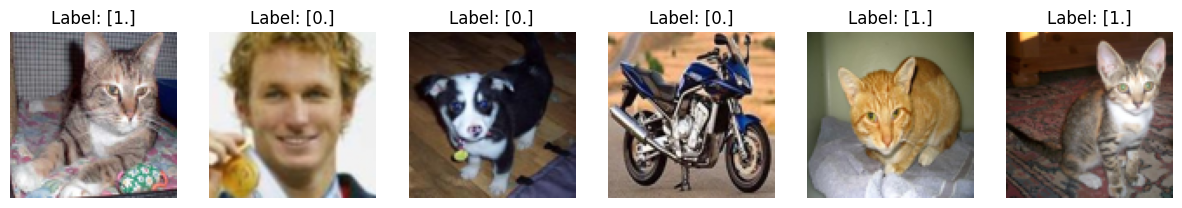

In [3]:
m = train_x.shape[0]

print("Number of training examples: "+str(m))
print(train_y.shape)
print(train_x.shape)
print(test_x.shape)
print(test_y.shape)

debug_labels(test_x, test_y)

<a name='1'></a>
## 1 - Initialization

When training neural networks, initializing the weights correctly is crucial for ensuring that the model converges efficiently. Poor initialization can lead to vanishing or exploding gradients, which make the learning process unstable or slow.

A Basic Initialization:

* If we initialize the weights all to zeros, we have a symmetry problem in which all neurons ends up learning the same. Every neuron in a layer will receive the same input, produce the same output, and thus, compute the same gradient during backpropagation.

* A common approach is to initialize the weights of a neural network by multiplying a random matrix by a small value, such as 0.01. This ensures that the initial weights are small, reducing the chance of large outputs in the early layers. However, this method has limitations, particularly in deeper networks, where it can lead to slow convergence or poor model performance.

Advanced Initialization Techniques:

1. **Xavier Initialization**,
Xavier Initialization (also known as Glorot Initialization) is designed to maintain the variance of activations across layers. It works well for activation functions like *tanh* or *sigmoid*. In this method, the weight matrix is multiplied by:
        $\sqrt{\frac{1}{\text{dims of previous layer}}}$



2. **He Initialization**,
a more advanced technique, particularly suited for ReLU (Rectified Linear Unit) activation functions, is He Initialization. This method is designed to prevent vanishing gradients in deep networks. The weight matrix is multiplied by:
        $\sqrt{\frac{2}{\text{dims of previous layer}}}$




*For this model I choose to apply the "He Initialization".*

In [4]:
# Initialization
def initialization_parameters_deep(layers_dims):

    parameters = {}
    L = len(layers_dims)

    for l in range(1, L):

        #He initialization
        parameters["W"+str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])        # He initialization.
        parameters["b"+str(l)] = np.zeros((layers_dims[l], 1))

    return parameters


<a name='2'></a>
# 2 - Forward Propagation

Forward propagation is the process which the input is pass through the neurons of the layers in order to produce an output. This is the same process in which the networks makes predictions.

Let's desglose the process step by step:

In each layer and each neuron, a series of computations occur:  

- 1. First, we compute the "Linear Transformation", the input from the previous layer is multiplied by the corresponding weights of that neuron, and then summed up along with a bias term. 
The formula:

$$
z^{[l]} = W^{[l]} \cdot a^{[l-1]} + b^{[l]}
$$

- 2. Secondly, we calculate the "Activation Function" the weighted sum calculted in step 1. $z^{[l]}$ is passed through a activation function, by this we introduce non-linearity into the network that allows the network to learn complex patterns in the data. Formula:

$$
a^{[l]} = g^{[l]}(z^{[l]})
$$



*In my model I use 'ReLU' activations and in the last layer 'Sigmoid'*.


This is done through all layers when going forward, finally I choose the 'Sigmoid' in the output layer that's because we are doing a classification task. 

In [5]:
#Step 1: Computation of Linear Transformation
def forward_linear_prop(A_prev, W, b):
    
    # Formula above (1)
    z = np.dot(W,A_prev) + b
    cache = (A_prev, W, b)

    return z, cache

#Step 2: Activation function
def linear_activation_forward(A_prev, W, b, activation):

    Z, cache_linear = forward_linear_prop(A_prev, W, b)     # Formula 1

    # Formula above (2). Depends on the activation
    if activation == "relu":
        a, cache_activation = relu(Z)
    
    elif activation == 'sigmoid':
        a, cache_activation = sigmoid(Z)

    cache = (cache_linear, cache_activation)

    return a, cache

In [6]:
#Step 3: Repeat the last process: Forward propagation through all layers.

"""
    X -->  (n_x,m) : Input data matrix
    parameters --> dictionary length L containing Weights and Bias for each layer in L
"""
def L_model_forward(X, parameters):

    caches = []                 # we save the the results, this makes more efficient retrieve the values in backpropagation 

    L = len(parameters) // 2
    A = X
    
    for l in range(1, L):
     
        A_prev = A

        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)

    #Last layer, sigmoid:
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
    caches.append(cache)

    return AL, caches

# 3 - Cost Function

For the purpose of my model (binary classification), I'm going to use the cost function **"Binary Cross-Entropy (Log Loss)"**. Formula:
$$
\text{Cost}(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$

We measures the performance (in cost terms) of the 'forward propagation' output of the classification model whose output is a probability value between 0 and 1.

In [7]:
""" Cost Function Module """
def bce_compute(AL, Y):

    m = Y.shape[1]  # number of examples

    epsilon = 1e-8
    AL = np.clip(AL, epsilon, 1 - epsilon)  # To Avoid log(0) or log(1-0)

    # formula above
    cost = -1/m * np.sum( Y * np.log(AL) + (1 - Y) * np.log(1-AL))

    return np.squeeze(cost)     # squeeze: removes single-dimensional entries

# 4.1 - Backward Propagation

Backward Propagation is the process used to compute the gradients of the loss function with respect to each weight and bias. The derivative is crucial for updating the weights and bias of the network.

The process step by step:

- 1. First, we calculate the derivative of the activation.
- 2. Second, we calculate the linear derivative.

Again, we do this process through all the layers.
 - We apply backward propagation after we have forwarded and calculate the loss of that forward propagation. 
 - From the last layer (output) until the first layer. We calculate the gradient of each node and store it for use it the update rule. 

In [8]:
#Step 1: computation linear backward:
def linear_backward(cache, dZ):

    A_prev, W, b = cache
    m = A_prev.shape[1]         # Number of training example

    # Gradients for Weigths, Biases and for previous Activation
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA = np.dot(W.T, dZ)

    return dW, db, dA

#Step 2: Computation backward activación so we calculate the gradients:
def linear_backward_prop(dA, cache, activation):

    linear_cache, activation_cache = cache

    dA_prev = None
    dW = None
    db = None

    # Compute dZ for ReLU or Sigmoid respectively and calls linear_backward
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(linear_cache, dZ)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(linear_cache, dZ)

    return dW, db, dA_prev

In [9]:
#Paso 3: Backward thorugh all layers.
"""
    AL -->      Output activations from the last layer (predictions) : (n_y,m)

    caches -->  List of caches from the forward pass. Each cache contains: 
                    1. Linear cache (A_prev, W, b) and 2. Activation cache (Z)
    
    Y --> True labels of the data : (n_y,m)
    
    lambd --> Regularization parameter (λ), used for L2 regularization (watch optimization_code.ipynb).

    dropout_prob and layers_drop --> hyperparameters (watch optimization_code.ipynb) 
"""
def L_model_backward(AL, caches, Y, lambd, dropout_prob=0, layers_drop=[0, 0, 0, 0, 0]):

    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    # Treatment last layer
    # Derivative of the cost with respect to AL, computed using the binary cross-entropy loss formula:
    dAL = - (np.divide(Y,AL) - np.divide(1-Y, 1-AL)) 

    # we retrieve all caches from prior last layer and compute one layer linear_backward for sigmoid activation
    current_cache = caches[L-1]
    linear_cache, _ = current_cache
    _, W, _ = linear_cache

    dW_prev, db_prev, dA_prev = linear_backward_prop(dAL, current_cache, activation="sigmoid")

    #L2 - regularization
    dW_prev += (lambd / m) * W

    # Store gradients for the next (prior) layer in backwards
    grads["dW"+str(L)] = dW_prev
    grads["db"+str(L)] = db_prev
    grads["dA"+str(L-1)] = dA_prev

    # The hidden layers use ReLU activation, and the process is repeated for each layer in reverse order.
    for l in reversed(range(L-1)):

        current_cache = caches[l]
        dA_curr = grads["dA" + str(l+1)]

        _, W, _ = current_cache[0]

        dW_prev, db_prev, dA_prev = linear_backward_prop(dA_curr, current_cache, activation="relu")

        #Add L2 - Regularización
        dW_prev += (lambd / m) * W

        grads["dW"+str(l+1)] = dW_prev
        grads["db"+str(l+1)] = db_prev
        grads["dA"+str(l)] = dA_prev
    
    return grads

# 4.2 - Update Parameters

During training, the network adjust its weights and biases to minimize the loss function. To minimize this loss, we use the **'Gradient Descent'**.

* **Gradient Descent**: It's an iterative algorithm for finding a local minimum. The idea is to take repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point, because this is the direction of steepest descent. The formula:
$$
\theta := \theta - \eta \frac{\partial \text{Cost}}{\partial \theta}
$$

- One way to visualize this is to think of a small marble that starts within the image at a random point (random initialization), with each step of the gradient formula we move towards a minimum, (like gravity, the marble moves towards below). 

- How large this step is is determined by the variable **$\eta$** (**'learning_rate'** and it's an hyperparameter). 
    - Care must be taken not to be too large so that it does not converge or too small so that the descent to the minimum point is very slow.

In [10]:
#Paso 4: Update parameters:
def update_parameters(params, grads, learning_rate):

    parameters = copy.deepcopy(params)

    L = len(parameters) // 2

    for l in range(L):
        
        # Formula above for parameters (weights and biases)
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate * grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]

    return parameters

* An improvement/optimization added to my model is the **learning_decay**, we reduce the learning_rate as we increase the iterations (so we are closer to the local minimum). 
    
    - 1) an initially large learning rate accelerates training or helps the network escape spurious local minima; 
    - 2) decaying the learning rate helps the network converge to a local minimum and avoid oscillation.

In [ ]:
""" Inverse Time Decay -- Exponential weigths decay """

def truncate(number, decimals):
    factor = 10.0 ** decimals
    
    return int(number * factor) / factor

def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=1000):

    learning_rate = learning_rate0 / (1 + decay_rate * np.floor(epoch_num/time_interval))
    
    learning_rate = truncate(learning_rate, 7)

    return learning_rate

# 5 - The Model Architecture.
 
We join all the steps in the function:

I decided to use Adam optimization because of its great performance in learning speed compared to Momentum or without optimization. Furthermore, you can choose:

* Without Regularization: optimizer = 0
* Try Avoid Overfitting with L2_regularization: optimizer = 1

*Due to be a small deep neural network it may be possible that Regularization techniques does not improve as it should.*

In [37]:
def deep_neuronal_model(X, Y, layers_dims, epsilon, lambd, mini_batch_size=64, dropout_rate=0, layers_drop=[0,0,0,0,0], beta1 = 0.9, beta2 = 0.99, 
                        learning_rate = 0.0075, num_epochs = 3000, decay_rate=0, time_interval=0, print_cost=False, optimizer=0):

    costs = [] # costs records
    
    parameters = initialization_parameters_deep(layers_dims)
    v, s = initialize_parameters_adam(parameters)

    #Iterate
    for i in range(num_epochs):

        # We create the mini-batches
        mini_batches = random_mini_batches(X, Y, mini_batch_size)
        t = 1

        # Learning decay, we update learning_rate
        if i % time_interval == 0:
            learning_rate = schedule_lr_decay(learning_rate, i, decay_rate, time_interval)

        if i % 25 == 0:
            print(learning_rate)


        # For each minibatch
        for mini_batch in mini_batches: # (mejora 1)
                    
            AL, caches = L_model_forward(X, parameters) #, dropout_rate, layers_drop) 

            
            if optimizer == 0:
                cost = bce_compute(AL, Y)
            elif optimizer == 1:
                cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
                
            costs.append(cost)

            #Backward_prop - 3
            grads = L_model_backward(AL, caches, Y, lambd) #, dropout_rate, layers_drop)

            parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, beta1, beta2, learning_rate, epsilon)
            t = t +1

        if print_cost and i % 25 == 0:
            print(f"Cost after iteration {i}: {cost}")

        if cost < 0.02:    # Early stop, avoid overfitting in a small dataset
            break

    
    return parameters, costs

# 6 - Training 

## 6.1 - Setting Up the images

One way to optimize and speed up training is by applying normalization to the input images. Thus, we guarantee that all features are in a similar scale and usually helps the learning algorithm run faster. 

* Nomalization:
$$
X_{\text{normalized}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

* In the context of images, pixels take a value in a range between 0 and 255. So the normalization is:  $X_{\text{normalized}} = \frac{X}{255}$.

Doing this, our data normalized will be always between 0 and 1.
It's important to **apply the same treatment to both train and dev set.** In general, we want our data both training and test examples to go through the same transformation defined.

* Finally, we have to pass to our model the images as a 1-Dimensional, so we flat the input before.

In [36]:
# Flatten the data
train_x_flatten = train_x.reshape(train_x.shape[0], -1).T
test_x_flatten = test_x.reshape(test_x.shape[0], -1).T



# Normalize the data. 
print("Pixel values range train:", np.min(train_x_flatten[10]), np.max(train_x_flatten[10]))    # It's already normalized from 'preprocess_data'
train_set_x = train_x_flatten # / 255.
test_set_x = test_x_flatten #/ 255.



#Reshape y for our model
train_set_y = train_y.transpose(0,1)
test_set_y = test_y.transpose(0,1)



print(train_set_x.shape)
print(train_set_y.shape)
print(test_set_x.shape)
print(test_set_y.shape)

Pixel values range train: 0.0 1.0
(27648, 560)
(1, 560)
(27648, 140)
(1, 140)


## 6.2 - Hyperparameters tunning and training

In [49]:
""" Training Module """
#arquitecture, layer dims
layers_dims = [27648, 20, 7, 5, 1]  # 4-layer           

#hyperparameters tunning
learning_rate = 0.001
beta1 = 0.9                 # Adam, how much previous gradients take account
beta2 = 0.99                # Adam, as RMSPROP beta
epsilon = 1e-8              #avoid dividing by 0
num_epochs = 351            
mini_batch_size = 64        #minibatches size


lambd = 0.01                 #L2 - regularization

dropout_prob = 0.1          # Dropout not used
layers_drop = [0,0,1,0,0]   # Dropout, which layer has dropout, not used

decay_rate = 0.002      
time_interval = 50          # interval which decay rate formula is used.


parameters, costs = deep_neuronal_model(train_set_x, train_set_y, 
                layers_dims, 
                epsilon, 
                lambd,
                mini_batch_size, 
                dropout_prob, 
                layers_drop, 
                beta1, 
                beta2, 
                learning_rate, 
                num_epochs,
                decay_rate, 
                time_interval,
                optimizer=0, 
                print_cost=True)

0.001
Cost after iteration 0: 0.6782650496168546
0.001
Cost after iteration 25: 0.20121186817528802
0.000998
Cost after iteration 50: 0.033266823178922635


In [52]:
#Save parameters, avoid training again
with open('parameters_saved/parameters_without_regularization','wb') as f:
    pickle.dump(parameters,f)

# 7 - Conclusion

In [26]:
def predict(X, y, parameters):

    m = X.shape[1]  # number examples
    print(f"Number of examples: {m}")
    n = len(parameters) // 2  # number of layers
    
    # Initialized predicts as zeros
    p = np.zeros((1, m))
    
    # Prediction, forward prop
    probas, caches = L_model_forward(X, parameters)
    
    # 
    p = (probas > 0.5).astype(int)
    
    # Accuracy
    accuracy = np.sum(p == y) / m

    print(f"Precisión: {accuracy:.2f}")
   
    return p

## 7.1 - Without Regularization

Relevant parameters:

* learning_rate: 0.001
* time_interval: 50
* decay_rate = 0.002
* batch_size = 64
* optimizer = 0

In [41]:
#load parameters 
with open('parameters_saved/parameters_without_regularization', 'rb') as f:
    parameters = pickle.load(f) 

In [50]:
pred_train = predict(train_set_x, train_set_y, parameters)

Number of examples: 560
Precisión: 1.00


In [51]:
pred_test = predict(test_set_x, test_set_y, parameters)

Number of examples: 140
Precisión: 0.71


## 7.2 - With Regularization

Relevant parameters:

* learning_rate = 0.0015
* time_interval = 40
* decay_rate = 0.005
* batch_size = 32
* lambd = 0.001
* optimizer = 1

In [44]:
with open('parameters_saved/parameters_with_regularization_L2', 'rb') as f:
    parameters = pickle.load(f) 

In [45]:
pred_train = predict(train_set_x, train_set_y, parameters)

Number of examples: 560
Precisión: 0.89


In [46]:
pred_test = predict(test_set_x, test_set_y, parameters)

Number of examples: 140
Precisión: 0.89


## Try with your own image

In [33]:
#Try own image
def predict_solo(image_path, parameters):

    X = preprocess_image(image_path)

    probas, caches = L_model_forward(X, parameters)
    
    print(str(probas))
    if probas >= 0.5:
        print("1")
    else:
        print("0")

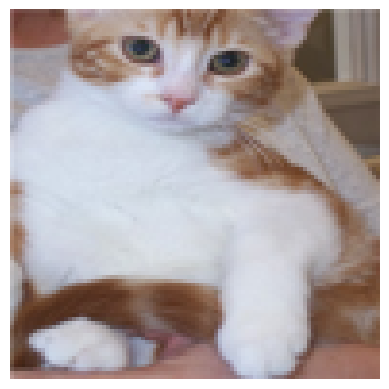

(27648, 1)
[[0.99987641]]
1


In [35]:
image_path = 'Datasets/working/test/Cat/9.jpg'  # path of the image you want to test

predict_solo(image_path, parameters)